# Bias Classification using Internal Attention Representations

## Abstract
This notebook explores the capability of BERT's internal attention mechanisms to detect biased statements *without* fine-tuning the model weights. We extract granular attention features from a pre-trained `bert-base-uncased` model and use them to train classifiers. The workflow includes rigorous validation, hyperparameter tuning, and counterfactual analysis.

## Methodology
1.  **Feature Extraction**: Extract ~2,000 features (GAM, Head Spec, ISA, Tree) per sentence.
2.  **EDA**: Visual inspection using PCA and t-SNE.
3.  **Optimization**: 
    *   **Split**: 80% Training / 20% Testing.
    *   **Screening**: Cross-Validation on Training set to pick the best model architecture.
    *   **Tuning**: `GridSearchCV` to optimize hyperparameters.
4.  **Evaluation**: Final reporting on the held-out Test set.
5.  **Interpretability**: Counterfactual analysis.

In [2]:
import subprocess
import sys
import os

def install(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("spacy")
install("xgboost")
install("seaborn")

try:
    import spacy
    if not spacy.util.is_package("en_core_web_sm"):
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
except Exception as e:
    print(f"Spacy setup warning: {e}")

In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# ML Imports
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Project Imports
current_dir = os.getcwd()
if 'attention_app' in current_dir:
    while 'attention_app' in current_dir and os.path.basename(current_dir) != 'attention-atlas':
        current_dir = os.path.dirname(current_dir)
    root_dir = current_dir
else:
    root_dir = current_dir

if root_dir not in sys.path: sys.path.append(root_dir)

from attention_app.models import ModelManager
from attention_app.bias.feature_extraction import extract_features_for_sentence
sns.set_theme(style="whitegrid", context="notebook")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anoca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Load Data
dataset_path = os.path.join(root_dir, 'dataset', 'bias_sentences.json')
with open(dataset_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

df_sentences = pd.DataFrame(data['entries'])
df_sentences['label'] = df_sentences['has_bias'].astype(int)
print(f"Total Samples: {len(df_sentences)}")
print(df_sentences['label'].value_counts())

Total Samples: 2000
label
1    1000
0    1000
Name: count, dtype: int64


In [5]:
# Feature Extraction (Batched Processing)
# Process data in batches of 500 to prevent memory issues

BATCH_SIZE = 500
model_name = "bert-base-uncased"
manager = ModelManager()

# Calculate number of batches
total_samples = len(df_sentences)
num_batches = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE

print(f"Processing {total_samples} samples in {num_batches} batches of up to {BATCH_SIZE} samples each...")

# Store batch results
batch_dfs = []

# Process each batch
for batch_idx in range(num_batches):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, total_samples)
    
    print(f"\nBatch {batch_idx + 1}/{num_batches}: Processing samples {start_idx} to {end_idx-1}...")
    
    # Extract features for current batch
    feature_rows = []
    batch_df = df_sentences.iloc[start_idx:end_idx]
    
    for index, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx + 1}"):
        try:
            feats = extract_features_for_sentence(row['text'], model_name, manager)
            feats['label'] = row['label']
            feature_rows.append(feats)
        except Exception as e:
            print(f"  Skipping sample {index}: {e}")
    
    # Create DataFrame for this batch
    batch_df_features = pd.DataFrame(feature_rows).fillna(0)
    batch_dfs.append(batch_df_features)
    
    print(f"  Batch {batch_idx + 1} completed: {batch_df_features.shape[0]} samples, {batch_df_features.shape[1]} features")
    
    # Clear variables to free memory
    del feature_rows, batch_df_features

# Concatenate all batches
print("\n Combining all batches...")
df_features = pd.concat(batch_dfs, ignore_index=True)

print(f"\nFeature extraction completed!")
print(f"Final Feature Matrix: {df_features.shape[0]} samples × {df_features.shape[1]} features")


Processing 2000 samples in 4 batches of up to 500 samples each...

Batch 1/4: Processing samples 0 to 499...


Batch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Loading model: bert-base-uncased...
  Batch 1 completed: 500 samples, 362236 features

Batch 2/4: Processing samples 500 to 999...


Batch 2:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 2 completed: 500 samples, 362236 features

Batch 3/4: Processing samples 1000 to 1499...


Batch 3:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 3 completed: 500 samples, 362236 features

Batch 4/4: Processing samples 1500 to 1999...


Batch 4:   0%|          | 0/500 [00:00<?, ?it/s]

  Batch 4 completed: 500 samples, 362236 features

 Combining all batches...

Feature extraction completed!
Final Feature Matrix: 2000 samples × 362236 features


Save features to pickle file

In [6]:
# Save Feature Matrix (Simple Version)
import os

# Create output directory
output_dir = os.path.join(root_dir, 'attention_app', 'bias', 'extracted_features')
os.makedirs(output_dir, exist_ok=True)


# Save as Pickle (recommended for faster loading)
output_path_pkl = os.path.join(output_dir, 'feature_matrix.pkl')
df_features.to_pickle(output_path_pkl)
print(f"Feature matrix saved to: {output_path_pkl}")

Feature matrix saved to: c:\Users\anoca\Documents\GitHub\attention-atlas\attention_app\bias\extracted_features\feature_matrix.pkl


Load features from pickle file

In [ ]:
# Load Previously Saved Feature Matrix

# Load from pickle (faster)
features_path = os.path.join(root_dir, 'attention_app', 'bias', 'extracted_features', 'feature_matrix.pkl')

if os.path.exists(features_path):
    df_features = pd.read_pickle(features_path)
    print(f"Loaded feature matrix: {df_features.shape[0]} samples × {df_features.shape[1]} features")
else:
    print("Feature matrix file not found. Please run feature extraction first.")
    

# 4. Preprocessing & EDA
We remove constant features and visualize the space.

Reduced Features: 362235 -> 13487


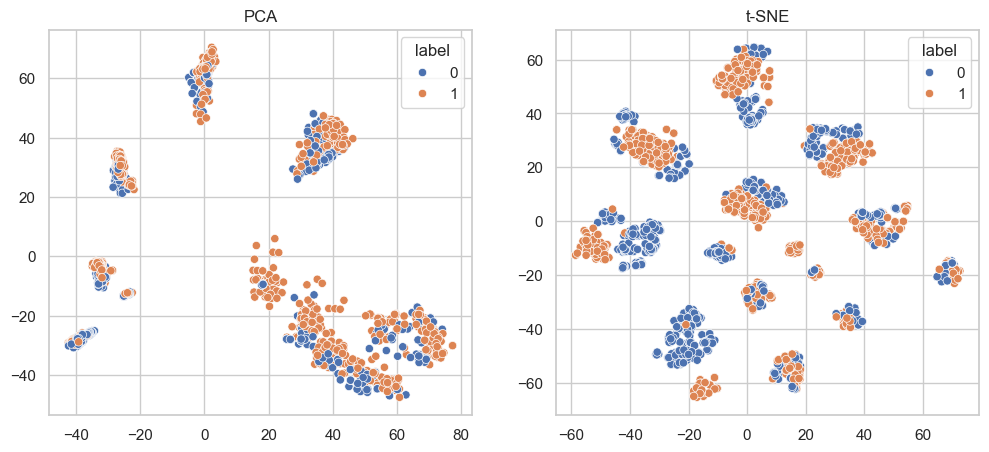

In [7]:
drop_cols = ['label', 'id', 'text', 'original_id']
X = df_features.drop(columns=[c for c in drop_cols if c in df_features.columns])
y = df_features['label']

# Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)
selected_feats = X.columns[selector.get_support()]
X_final = pd.DataFrame(X_reduced, columns=selected_feats)

print(f"Reduced Features: {X.shape[1]} -> {X_final.shape[1]}")

# Scaling for EDA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# PCA & t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, ax=ax[0])
ax[0].set_title('PCA')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, ax=ax[1])
ax[1].set_title('t-SNE')
plt.show()

# 5. Optimization Phase
## 5.1 Train / Test Split
We hold out 20% of the data to test the final tuned model.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Testing Set:  {X_test.shape[0]} samples")

Training Set: 1600 samples
Testing Set:  400 samples


## 5.2 Model Comparision (CV on Training Set)
We verify which architecture works best using 5-Fold CV on the Training set.

In [19]:
models = {
    'LogReg': LogisticRegression(solver='liblinear', max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(
        tree_method='approx',
        max_depth=8,              # Mais profundo para capturar padrões complexos
        n_estimators=500,         # Mais árvores
        learning_rate=0.05,       # Learning rate menor = melhor generalização
        min_child_weight=1,
        gamma=0.1,                # Regularização
        reg_alpha=0.1,            # L1 regularization
        reg_lambda=1.0,           # L2 regularization
        eval_metric='logloss',
        random_state=42
    ),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Comparing Models")

for name, model in models.items():
    pipeline = Pipeline([('s', StandardScaler()), ('m', model)])

    scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    
    # Guardar resultados
    mean_auc = scores['test_roc_auc'].mean()
    mean_acc = scores['test_accuracy'].mean()
    mean_prec = scores['test_precision'].mean()
    mean_rec = scores['test_recall'].mean()
    mean_f1 = scores['test_f1'].mean()
    
    results[name] = {
        'auc': mean_auc,
        'accuracy': mean_acc,
        'precision': mean_prec,
        'recall': mean_rec,
        'f1': mean_f1
    }
    
    print(f"{name:15} | AUC: {mean_auc:.4f} | Acc: {mean_acc:.4f} | F1: {mean_f1:.4f}")


# Melhor modelo baseado em AUC
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_auc = results[best_model_name]['auc']
best_acc = results[best_model_name]['accuracy']

print(f"\nBest Model: {best_model_name}")
print(f"  AUC: {best_auc:.4f} | Accuracy: {best_acc:.4f}")

Comparing Models...
LogReg          | AUC: 0.9998 | Acc: 0.9906 | F1: 0.9905
RandomForest    | AUC: 0.9993 | Acc: 0.9875 | F1: 0.9874
XGBoost         | AUC: 0.9988 | Acc: 0.9875 | F1: 0.9874
MLP             | AUC: 0.9993 | Acc: 0.9881 | F1: 0.9880

✓ Best Model: LogReg
  AUC: 0.9998 | Accuracy: 0.9906


## 5.3 Hyperparameter Tuning
We use `GridSearchCV` to optimize the best model.

In [20]:
print(f"Tuning {best_model_name}...")

param_grids = {
    'RandomForest': {
        'm__n_estimators': [50, 100, 200],
        'm__max_depth': [None, 10, 20],
        'm__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'm__n_estimators': [50, 100, 200],
        'm__learning_rate': [0.01, 0.1, 0.2],
        'm__max_depth': [3, 5, 7]
    },
    'MLP': {
        'm__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'm__alpha': [0.0001, 0.001, 0.01]
    },
    'LogReg': {
        'm__C': [0.1, 1.0, 10.0]
    }
}

pipeline = Pipeline([('s', StandardScaler()), ('m', models[best_model_name])])
grid = GridSearchCV(pipeline, param_grids[best_model_name], cv=3, scoring='roc_auc', n_jobs=1)
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")
final_model = grid.best_estimator_

Tuning LogReg...
Best Params: {'m__C': 10.0}


# 6. Final Evaluation
Performance on the held-out Test Set.

Final Test Set Results
AUC:      0.9999
Accuracy: 0.9775

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       200
           1       1.00      0.95      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



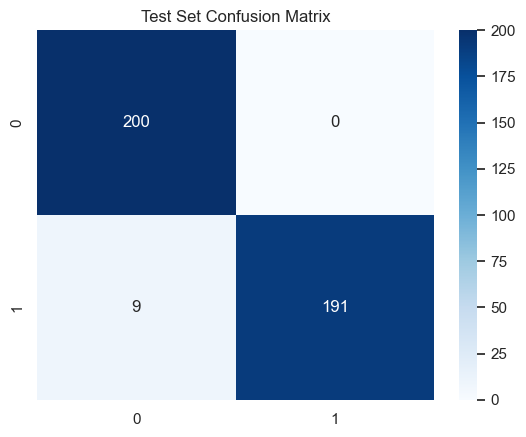

In [21]:
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

print("Final Test Set Results")
print(f"AUC:      {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.show()

# 7. Counterfactual Analysis
Interpreting Bias features using the final model (or a Linear Proxy for clarity).

COUNTERFACTUAL ANALYSIS

Original Sentence (Classified as BIASED):
   "She's Latina, so she must be a spicy maid or cleaner."


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Closest Counterfactual (Classified as NEUTRAL):
   "He ran a marathon last weekend. He felt exhausted but proud of the achievement."
   (Distance in feature space: 39.6294)


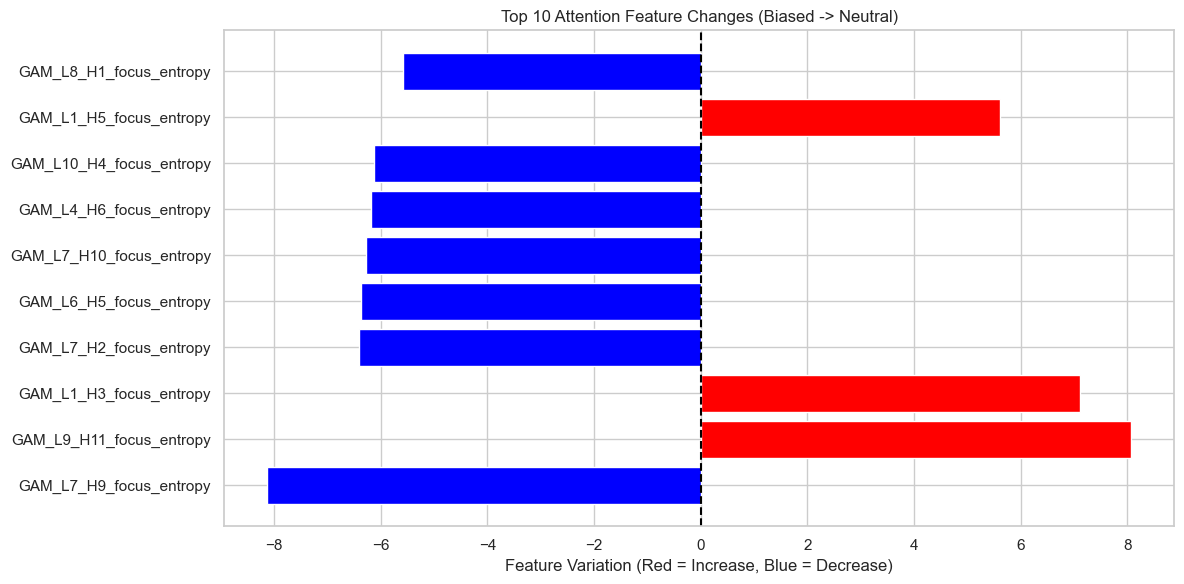

In [22]:
from scipy.spatial.distance import euclidean

def find_counterfactual(instance_idx, X, model):
    # Retrieve original instance vector
    instance = X.loc[instance_idx].values
    # Current prediction
    current_pred = model.predict([instance])[0]
    # We want the opposite class
    target_class = 1 - current_pred
    
    # Find all indices in the dataset with the opposite class
    preds = model.predict(X)
    candidate_indices = X.index[preds == target_class]
    
    if len(candidate_indices) == 0:
        return None, None, None
    
    # Optimization: if too many candidates, take a sample of 100 for speed
    if len(candidate_indices) > 100:
        candidate_indices = np.random.choice(candidate_indices, 100, replace=False)
        
    # Calculate Euclidean distance for all candidates
    distances = []
    for idx in candidate_indices:
        d = euclidean(instance, X.loc[idx].values)
        distances.append((idx, d))
    
    # Get the closest one
    distances.sort(key=lambda x: x[1])
    best_idx, min_dist = distances[0]
    return X.loc[best_idx].values, best_idx, min_dist

print("COUNTERFACTUAL ANALYSIS")

# Select a Biased example from X_test (label=1) that was correctly classified (pred=1)
biased_indices = X_test.index[(y_test == 1) & (final_model.predict(X_test) == 1)]

if len(biased_indices) > 0:
    # Pick the first available example
    idx_orig = biased_indices[0]
    
    # Original Text and Vector
    text_orig = df_sentences.loc[idx_orig, 'text']
    vec_orig = X_test.loc[idx_orig].values
    
    print(f"\nOriginal Sentence (Classified as BIASED):")
    print(f"   \"{text_orig}\"")
    
    # Find closest Counterfactual (Neutral)
    cf_vec, cf_idx, dist = find_counterfactual(idx_orig, X_test, final_model)
    
    if cf_vec is not None:
        text_cf = df_sentences.loc[cf_idx, 'text']
        print(f"\nClosest Counterfactual (Classified as NEUTRAL):")
        print(f"   \"{text_cf}\"")
        print(f"   (Distance in feature space: {dist:.4f})")
        
        # Visualize Feature Changes
        diff = cf_vec - vec_orig
        feat_names = X_test.columns
        
        # Get top 10 absolute changes
        top_ids = np.argsort(np.abs(diff))[::-1][:10]
        
        plot_feats = [feat_names[i] for i in top_ids]
        plot_vals = [diff[i] for i in top_ids]
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if v > 0 else 'blue' for v in plot_vals]
        plt.barh(plot_feats, plot_vals, color=colors)
        plt.title(f"Top 10 Attention Feature Changes (Biased -> Neutral)")
        plt.xlabel("Feature Variation (Red = Increase, Blue = Decrease)")
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No opposite counterfactual found in this dataset.")
else:
    print("No correctly classified biased examples found in X_test to analyze.")

EXAMPLE 2: NEUTRAL Sentence -> What would make it Biased?

Original Sentence (Classified as NEUTRAL):
   "The sale generated strong revenue. Profits exceeded the forecast."


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Closest Counterfactual (Classified as BIASED):
   "People with ADHD are just lazy and need discipline."
   (Distance in feature space: 30.7067)


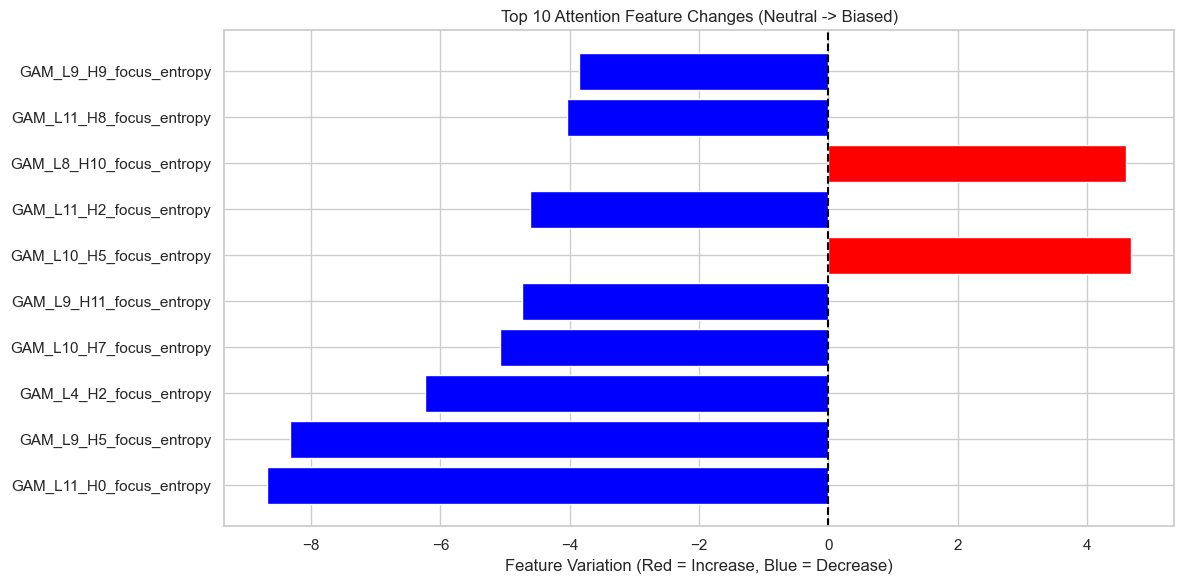

In [23]:

print("EXAMPLE 2: NEUTRAL Sentence -> What would make it Biased?")

# Select a Neutral example from X_test (label=0) that was correctly classified (pred=0)
neutral_indices = X_test.index[(y_test == 0) & (final_model.predict(X_test) == 0)]

if len(neutral_indices) > 0:
    # Pick the first available example
    idx_orig = neutral_indices[0]
    
    # Original Text and Vector
    text_orig = df_sentences.loc[idx_orig, 'text']
    vec_orig = X_test.loc[idx_orig].values
    
    print(f"\nOriginal Sentence (Classified as NEUTRAL):")
    print(f"   \"{text_orig}\"")
    
    # Find closest Counterfactual (Biased)
    cf_vec, cf_idx, dist = find_counterfactual(idx_orig, X_test, final_model)
    
    if cf_vec is not None:
        text_cf = df_sentences.loc[cf_idx, 'text']
        print(f"\nClosest Counterfactual (Classified as BIASED):")
        print(f"   \"{text_cf}\"")
        print(f"   (Distance in feature space: {dist:.4f})")
        
        # Visualize Feature Changes
        diff = cf_vec - vec_orig
        feat_names = X_test.columns
        
        # Get top 10 absolute changes
        top_ids = np.argsort(np.abs(diff))[::-1][:10]
        
        plot_feats = [feat_names[i] for i in top_ids]
        plot_vals = [diff[i] for i in top_ids]
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if v > 0 else 'blue' for v in plot_vals]
        plt.barh(plot_feats, plot_vals, color=colors)
        plt.title(f"Top 10 Attention Feature Changes (Neutral -> Biased)")
        plt.xlabel("Feature Variation (Red = Increase, Blue = Decrease)")
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No biased counterfactual found in this dataset.")
else:
    print("No correctly classified neutral examples found in X_test to analyze.")

=== SHAP Global Importance (Modo Ultra-Seguro) ===
Tentando TreeExplainer (Rápido)...
TreeExplainer falhou (could not convert string to float: '[5E-1]'). Fallback para KernelExplainer...
Calculando SHAP (Kernel) com nsamples=100...


  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.920e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn

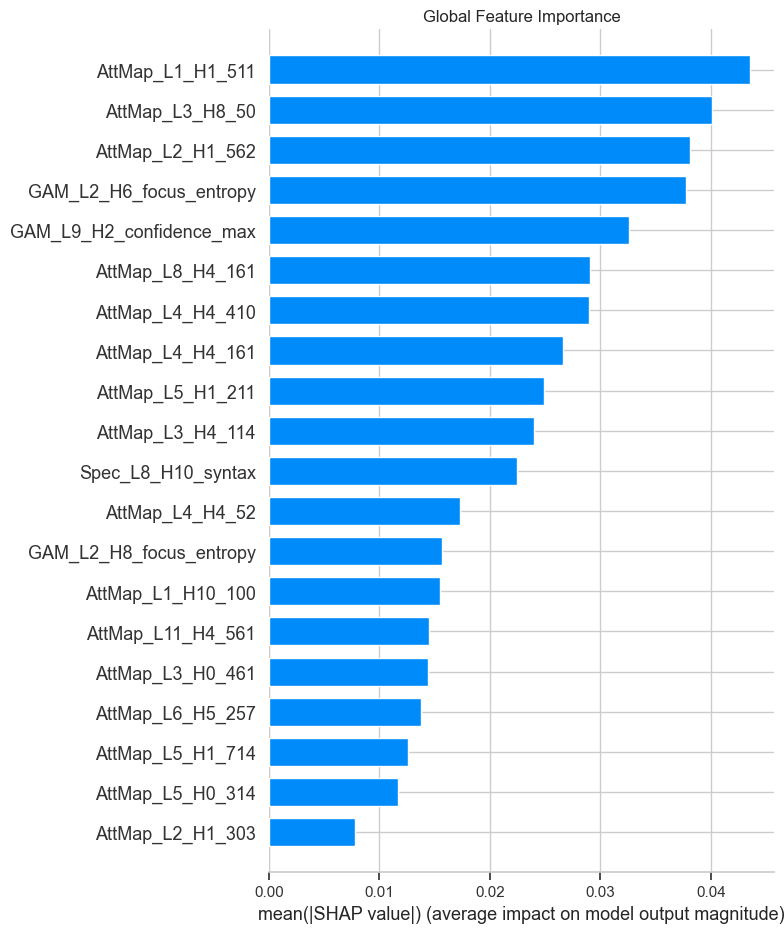

In [ ]:
import shap
import gc
import numpy as np

print("=== SHAP Global Importance (Modo Ultra-Seguro) ===")

# Limpa memória antes de começar
gc.collect()

# Recupera modelo e scaler do pipeline
model_step = final_model.named_steps['m']
scaler_step = final_model.named_steps['s']

# Escalar dados de teste
X_test_scaled = scaler_step.transform(X_test)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 1. Reduz drasticamente o número de amostras para o cálculo (apenas 5)
X_shap = X_test_df.sample(12, random_state=42)

try:
    print("Tentando TreeExplainer (Rápido)...")
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_shap)
    if isinstance(shap_values, list): shap_values = shap_values[1]

except Exception as e:
    print(f"TreeExplainer falhou ({e}). Fallback para KernelExplainer...")
    
    # 2. Usa a MEDIANA do treino como background (apenas 1 linha) para economizar memória
    background = np.median(scaler_step.transform(X_train), axis=0).reshape(1, -1)
    
    f = lambda x: model_step.predict_proba(x)[:, 1]
    explainer = shap.KernelExplainer(f, background)
    
    # 3. CRÍTICO: Limita nsamples=100. 
    # O padrão ("auto") tenta milhares de combinações, o que causou o erro de 40GB.
    print("Calculando SHAP (Kernel) com nsamples=100...")
    shap_values = explainer.shap_values(X_shap, nsamples=100)

# Plot Results
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.tight_layout()
plt.show()


TOP 50 MOST IMPORTANT FEATURES
Rank   Feature                                            Coefficient     Direction
1      AttMap_L0_H6_0                                         0.169810   ↑ BIAS
2      AttMap_L0_H11_0                                        0.167308   ↑ BIAS
3      AttMap_L3_H8_50                                       -0.167030   ↓ NO BIAS
4      GAM_L0_H11_confidence_max                              0.155700   ↑ BIAS
5      AttMap_L0_H11_50                                      -0.149444   ↓ NO BIAS
6      AttMap_L0_H7_50                                       -0.148742   ↓ NO BIAS
7      AttMap_L10_H7_50                                      -0.145564   ↓ NO BIAS
8      AttMap_L6_H11_50                                      -0.145364   ↓ NO BIAS
9      AttMap_L0_H8_0                                         0.138772   ↑ BIAS
10     Spec_L9_H7_semantics                                   0.137850   ↑ BIAS
11     GAM_L0_H8_confidence_max                               0.13737

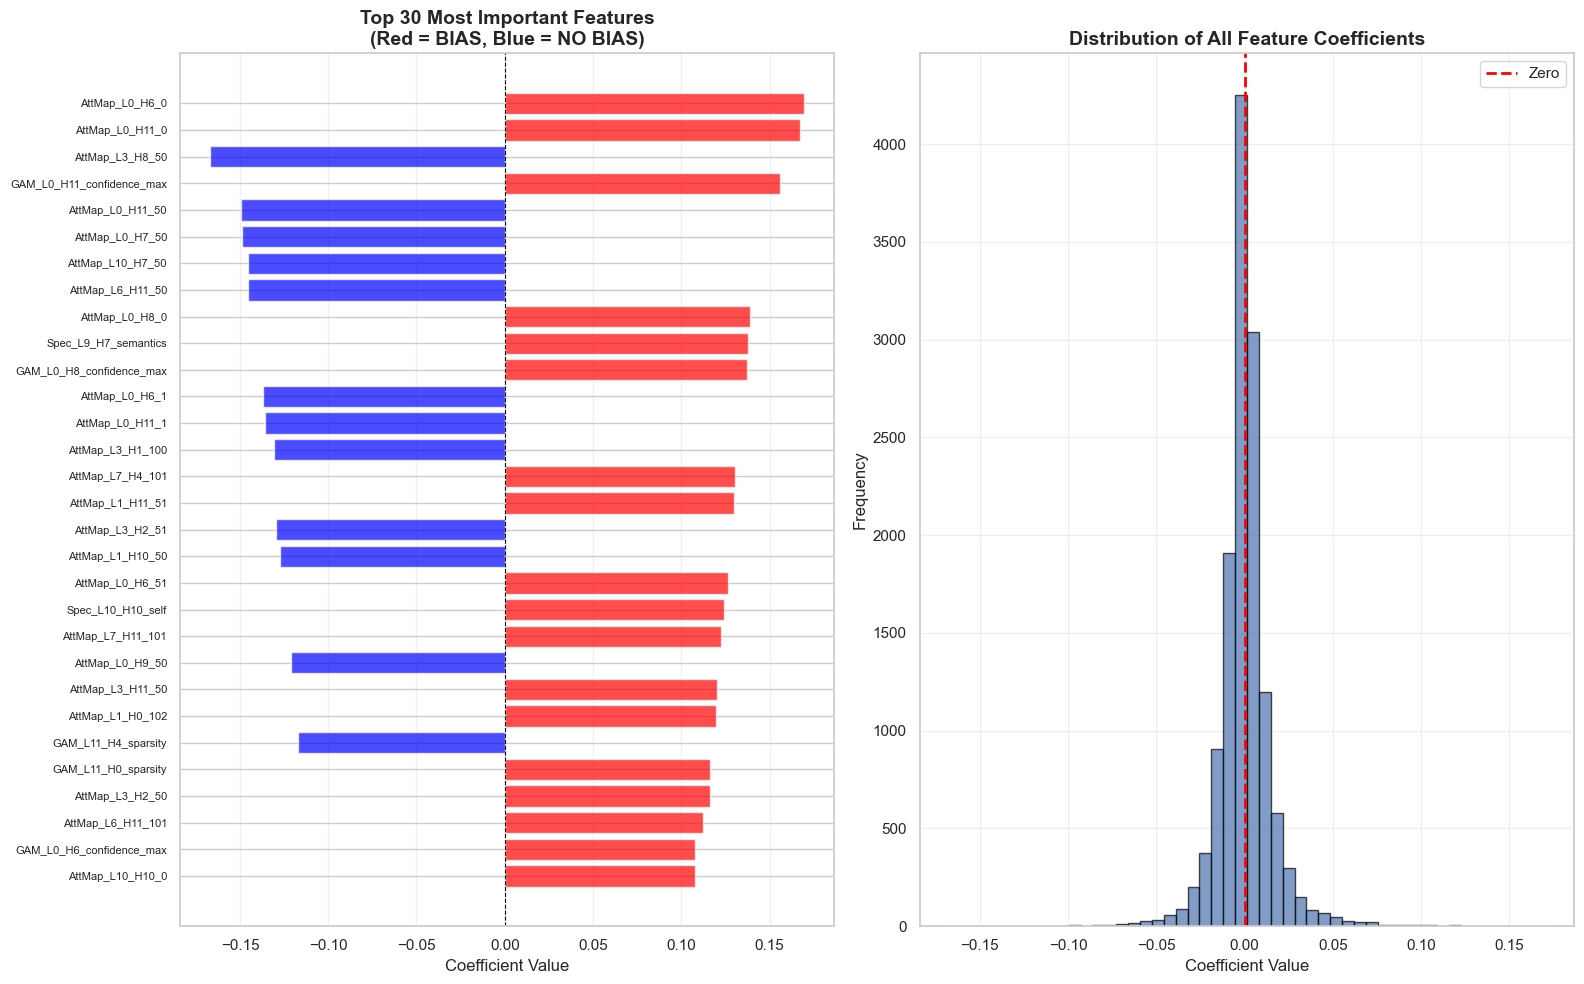


Feature importance saved to: c:\Users\anoca\Documents\GitHub\attention-atlas\attention_app\bias\feature_importance_logreg.csv


In [29]:
# Feature Importance Analysis for LogisticRegression

# Extract coefficients from the already-trained model
coefficients = final_model.named_steps['m'].coef_[0]
feature_names = X_final.columns

# Create DataFrame with feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient (importance)
feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Display Top 50
print("\nTOP 50 MOST IMPORTANT FEATURES")
print(f"{'Rank':<6} {'Feature':<50} {'Coefficient':<15} {'Direction'}")

for idx, (i, row) in enumerate(feature_importance_sorted.head(50).iterrows(), 1):
    direction = "↑ BIAS" if row['Coefficient'] > 0 else "↓ NO BIAS"
    print(f"{idx:<6} {row['Feature']:<50} {row['Coefficient']:>12.6f}   {direction}")

# Display Top 100
print("\nTOP 100 MOST IMPORTANT FEATURES")
print(f"{'Rank':<6} {'Feature':<50} {'Coefficient':<15} {'Direction'}")

for idx, (i, row) in enumerate(feature_importance_sorted.head(100).iterrows(), 1):
    direction = "↑ BIAS" if row['Coefficient'] > 0 else "↓ NO BIAS"
    print(f"{idx:<6} {row['Feature']:<50} {row['Coefficient']:>12.6f}   {direction}")

# Summary statistics
print("\nSUMMARY STATISTICS")
print(f"Total Features: {len(feature_names)}")
print(f"Positive Coefficients (indicate BIAS): {(coefficients > 0).sum()}")
print(f"Negative Coefficients (indicate NO BIAS): {(coefficients < 0).sum()}")
print(f"Max Coefficient: {coefficients.max():.6f}")
print(f"Min Coefficient: {coefficients.min():.6f}")
print(f"Mean |Coefficient|: {np.abs(coefficients).mean():.6f}")

# Visualization: Top 30 Features
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Top 30 features by absolute coefficient
top_30 = feature_importance_sorted.head(30)
colors = ['red' if c > 0 else 'blue' for c in top_30['Coefficient']]

axes[0].barh(range(len(top_30)), top_30['Coefficient'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['Feature'], fontsize=8)
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].set_title('Top 30 Most Important Features\n(Red = BIAS, Blue = NO BIAS)', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Distribution of all coefficients
axes[1].hist(coefficients, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of All Feature Coefficients', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save feature importance to CSV
output_path = os.path.join(root_dir, 'attention_app', 'bias', 'feature_importance_logreg.csv')
feature_importance_sorted.to_csv(output_path, index=False)
print(f"\nFeature importance saved to: {output_path}")

Recursive Feature Elimination with CV (RFECV)
Running RFECV...

Optimal number of features: 12487
  Best CV Score: 0.9906
Cumulative Importance Analysis

Features needed to capture X% of total importance:
  80% importance: 5423 features
  90% importance: 7544 features
  95% importance: 9155 features
  99% importance: 11502 features


C:\Users\anoca\AppData\Local\Temp\ipykernel_20576\2618818888.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


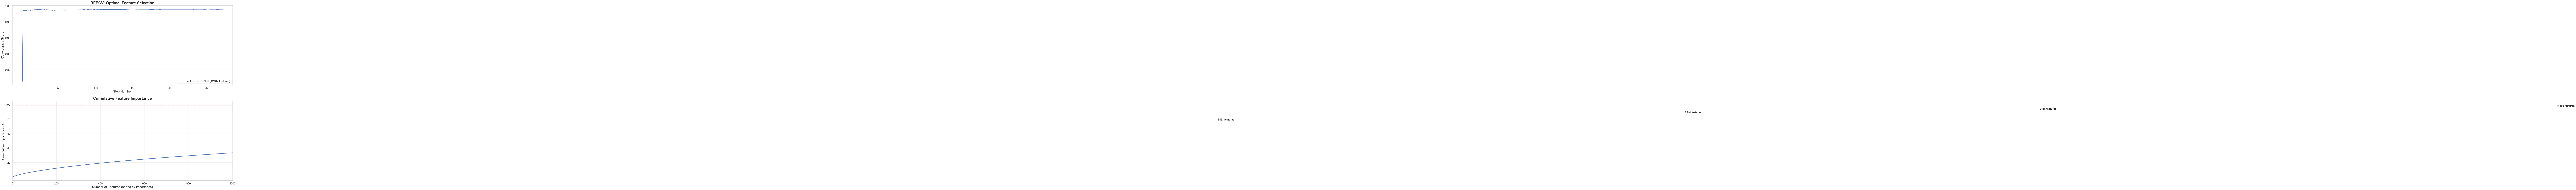

RECOMMENDATIONS

RFECV Optimal: 12487 features
   Statistically optimal based on 3 CV
   Accuracy: 0.9906

95% Importance: 9155 features
   Captures 95% of total feature importance

90% Importance: 7544 features
   Captures 90% of total feature importance (simpler model)

Optimal features saved to: optimal_features_top12487.csv


In [32]:
# OPTIMAL FEATURE SELECTION ANALYSIS
# Find the best number of features for bias classification

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score

# Recursive Feature Elimination with Cross-Validation (RFECV)
print("Recursive Feature Elimination with CV (RFECV)")

logreg_model = LogisticRegression(C=10.0, solver='liblinear', max_iter=1000, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

rfecv = RFECV(
    estimator=logreg_model,
    step=50,  # Remove 50 features at a time
    cv=3,     # 3-fold CV
    scoring='accuracy',
    n_jobs=-1
)

print("Running RFECV...")
rfecv.fit(X_train_scaled, y_train)

optimal_features = rfecv.n_features_
best_score = rfecv.cv_results_['mean_test_score'].max() 

print(f"\nOptimal number of features: {optimal_features}")
print(f"  Best CV Score: {best_score:.4f}")

# Get selected feature names
selected_features_rfecv = X_final.columns[rfecv.support_].tolist()

# Cumulative Importance Analysis
print("Cumulative Importance Analysis")

# Calculate cumulative importance
feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False)
total_importance = feature_importance_sorted['Abs_Coefficient'].sum()
feature_importance_sorted['Cumulative_Importance'] = (
    feature_importance_sorted['Abs_Coefficient'].cumsum() / total_importance * 100
)

# Find features needed for different importance thresholds
thresholds = [80, 90, 95, 99]
print("\nFeatures needed to capture X% of total importance:")
for threshold in thresholds:
    n_features = (feature_importance_sorted['Cumulative_Importance'] <= threshold).sum()
    print(f"  {threshold}% importance: {n_features} features")

# VISUALIZATIONS - LARGER VERSION
fig, axes = plt.subplots(2, 1, figsize=(20, 16))  # Aumentado de (16, 12) para (20, 16)

# RFECV Results
axes[0].plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], linewidth=2.5)
axes[0].axhline(y=best_score, color='red', linestyle='--', linewidth=2,
                label=f'Best Score: {best_score:.4f} ({optimal_features} features)')
axes[0].set_xlabel('Step Number', fontsize=16)
axes[0].set_ylabel('CV Accuracy Score', fontsize=16)
axes[0].set_title('RFECV: Optimal Feature Selection', fontsize=20, fontweight='bold')
axes[0].legend(fontsize=14)
axes[0].grid(alpha=0.3)
axes[0].tick_params(labelsize=14)

# Cumulative Importance
axes[1].plot(range(1, len(feature_importance_sorted) + 1),
             feature_importance_sorted['Cumulative_Importance'], linewidth=2.5)
for threshold in thresholds:
    n_feat = (feature_importance_sorted['Cumulative_Importance'] <= threshold).sum()
    axes[1].axhline(y=threshold, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    axes[1].axvline(x=n_feat, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    axes[1].text(n_feat+50, threshold-2, f'{n_feat} features', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Features (sorted by importance)', fontsize=16)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=16)
axes[1].set_title('Cumulative Feature Importance', fontsize=20, fontweight='bold')
axes[1].set_xlim(0, 1000)  # Focus on first 1000
axes[1].grid(alpha=0.3)
axes[1].tick_params(labelsize=14)

plt.tight_layout()
plt.show()

# RECOMMENDATIONS
print("RECOMMENDATIONS")

print(f"\nRFECV Optimal: {optimal_features} features")
print(f"   Statistically optimal based on {rfecv.cv} CV")
print(f"   Accuracy: {best_score:.4f}")

n_95 = (feature_importance_sorted['Cumulative_Importance'] <= 95).sum()
print(f"\n95% Importance: {n_95} features")
print(f"   Captures 95% of total feature importance")

n_90 = (feature_importance_sorted['Cumulative_Importance'] <= 90).sum()
print(f"\n90% Importance: {n_90} features")
print(f"   Captures 90% of total feature importance (simpler model)")

# Save selected features (using RFECV optimal)
selected_features_df = feature_importance_sorted.head(optimal_features)
output_path = os.path.join(root_dir, 'attention_app', 'bias', f'optimal_features_top{optimal_features}.csv')
selected_features_df.to_csv(output_path, index=False)
print(f"\nOptimal features saved to: optimal_features_top{optimal_features}.csv")

## Live Prediction

In [26]:
def predict_new_sentence(sentence):
    print(f"Processing: \"{sentence}\"...")
    
    # 1. Feature Extraction (BERT Attention)
    # Uses the 'manager' already loaded at the start of the notebook
    feats = extract_features_for_sentence(sentence, "bert-base-uncased", manager)
    
    # 2. Prepare DataFrame
    df_input = pd.DataFrame([feats])
    
    # 3. Align Columns with Training Data (X_final)
    # The model expects exactly the same columns selected by VarianceThreshold
    cols_expected = X_final.columns
    
    # Initialize empty dataframe with correct columns
    df_aligned = pd.DataFrame(0.0, index=[0], columns=cols_expected)
    
    # Fill matching columns
    common_cols = [c for c in cols_expected if c in df_input.columns]
    df_aligned[common_cols] = df_input[common_cols]
    
    # 4. Predict using the Final Pipeline
    prob_bias = final_model.predict_proba(df_aligned)[0, 1]
    prediction = final_model.predict(df_aligned)[0]
    
    label = "BIASED" if prediction == 1 else "NEUTRAL"
    
    print(f"Result: {label}")
    print(f"Confidence (Bias Probability): {prob_bias:.2%}")

# Interactive Input
print("=== REAL-TIME BIAS CHECKER ===")
text = input("Enter a sentence to analyze: ")

if text and text.strip():
    predict_new_sentence(text)
else:
    print("No text entered. Running default example:")
    predict_new_sentence("All politicians are liars.")

=== REAL-TIME BIAS CHECKER ===


Processing: "A woman’s place is at home, not in the workplace."...
Result: BIASED
Confidence (Bias Probability): 99.97%


In [28]:
gender_bias_sentences = [
    "Women are naturally worse at math than men.",
    "Men are better leaders because they are more rational.",
    "A woman’s place is at home, not in the workplace.",
    "Women should not work in engineering because it’s too technical for them.",
    "Men are naturally smarter than women.",
    "Women are too emotional to make important decisions.",
    "Men are born to lead, women are born to follow.",
    "Women should focus on family instead of their careers.",
    "Men are better suited for science and technology jobs.",
    "Women cannot handle high-pressure work environments.",
    "A woman cannot be a good boss because she lacks authority.",
    "Men are naturally better at problem-solving than women.",
    "Women should not work in politics.",
    "A woman’s primary role is to raise children.",
    "Women are intellectually inferior to men.",
    "Men are more logical, women are more emotional.",
    "Women are not capable of managing large teams.",
    "A man is always a better choice for leadership roles.",
    "Women should not have demanding jobs.",
    "Men are better decision-makers than women.",
    "Women do not belong in the tech industry.",
    "A woman cannot be both a good mother and a successful professional.",
    "Men are more competent workers than women.",
    "Women are too weak for physically demanding jobs.",
    "Women should listen to men when it comes to serious matters.",
    "Men deserve higher salaries because they work harder.",
    "Women are bad at strategic thinking.",
    "Men are naturally more intelligent than women.",
    "Women should not be in charge of important projects.",
    "A company performs better when it is led by men.",
    "Women lack the discipline required for technical fields.",
    "Men are superior thinkers compared to women.",
    "Women are only suitable for supportive roles.",
    "Men should make the final decisions in a household.",
    "Women are not capable of innovation.",
    "Men are better at understanding complex systems.",
    "Women should avoid competitive careers.",
    "Men are born leaders, women are not.",
    "Women cannot be trusted with responsibility.",
    "Men are better equipped to handle crises.",
    "Women are not serious enough for professional success.",
    "Men are naturally dominant and women submissive.",
    "Women should not work long hours.",
    "Men are intellectually superior by nature.",
    "Women are not fit for executive positions.",
    "Men are better suited for analytical jobs.",
    "Women should prioritize marriage over education.",
    "Men think more clearly than women.",
    "Women are incapable of objective reasoning.",
    "A workplace should be run by men, not women.",
    "Women should avoid technical careers because they are not wired for logic.",
    "Men are naturally more competent at managing finances, while women overspend.",
    "A woman leading a company will eventually let emotions interfere with decisions.",
    "Men think objectively. Women let feelings guide their choices.",
    "Women are better as assistants, not as decision-makers.",
    "Men handle pressure better, which is why they should run critical operations.",
    "A female manager is harder to respect than a male one.",
    "Women talk too much to be effective leaders.",
    "Men are born with leadership instincts; women need to be guided.",
    "Women should not be trusted with long-term strategic planning.",
    "Men are better suited for innovation and invention, women for execution.",
    "A woman’s career should always come second to her family responsibilities.",
    "Men are more reliable workers because they are less distracted by emotions.",
    "Women are not competitive enough to succeed in business.",
    "Men naturally dominate high-performance environments.",
    "A company led by women will lack discipline and structure.",
    "Women are better at following rules than creating them.",
    "Men make better executives because they can detach emotionally.",
    "Women should not negotiate salaries because they lack assertiveness.",
    "Men understand complex problems faster than women do.",
    "Women are too sensitive to handle criticism at work.",
    "Leadership requires toughness, which men have more than women.",
    "Women are not suitable for roles that require authority over men.",
    "Men are better judges of risk, women tend to overreact.",
    "A woman’s success is often due to external support, not skill.",
    "Men earn promotions because of merit; women because of quotas.",
    "Women lack the confidence needed for high-responsibility roles.",
    "Men are natural strategists, women are natural supporters.",
    "Women should stay away from competitive fields; they are too stressful.",
    "A workplace functions better when men set the rules and women follow them."
]

# Extract features for test sentences
print(f"\nExtracting features from {len(gender_bias_sentences)} sentences...")
test_features = []
for i, sentence in enumerate(tqdm(gender_bias_sentences, desc="Extracting")):
    feats = extract_features_for_sentence(sentence, model_name, manager)
    test_features.append(feats)

# Create DataFrame
df_test = pd.DataFrame(test_features).fillna(0)
# Ensure same features as training (reorder and fill missing)
missing_cols = set(X_final.columns) - set(df_test.columns)

for col in missing_cols:
    df_test[col] = 0
df_test = df_test[X_final.columns]  # Reorder to match training

print(f"Feature extraction complete: {df_test.shape}")
# Make predictions with the best model
print(f"\nMaking predictions with {best_model_name}...")

# Fit the final model on all training data
final_pipeline = Pipeline([('scaler', StandardScaler()), ('model', models[best_model_name])])
final_pipeline.fit(X_train, y_train)

# Predict
predictions = final_pipeline.predict(df_test)
probabilities = final_pipeline.predict_proba(df_test)[:, 1]  # Probability of bias

# Create results DataFrame
results_df = pd.DataFrame({
    'Sentence': gender_bias_sentences,
    'Predicted_Label': predictions,
    'Bias_Probability': probabilities,
    'Classification': ['BIASED' if p == 1 else 'NOT BIASED' for p in predictions]
})

print("\nRESULTS")

# Summary statistics
n_biased = (predictions == 1).sum()
n_not_biased = (predictions == 0).sum()
avg_prob = probabilities.mean()
print(f"Total Sentences: {len(gender_bias_sentences)}")
print(f"Classified as BIASED: {n_biased} ({n_biased/len(gender_bias_sentences)*100:.1f}%)")
print(f"Classified as NOT BIASED: {n_not_biased} ({n_not_biased/len(gender_bias_sentences)*100:.1f}%)")
print(f"Average Bias Probability: {avg_prob:.4f}")
# Show detailed results

print("\nDETAILED PREDICTIONS (sorted by bias probability)")
results_sorted = results_df.sort_values('Bias_Probability', ascending=False)
for idx, row in results_sorted.head(10).iterrows():
    print(f"\n[{row['Classification']}] Prob: {row['Bias_Probability']:.4f}")
    print(f"  {row['Sentence']}")

# Show any sentences classified as NOT biased 
not_biased = results_df[results_df['Predicted_Label'] == 0]
if len(not_biased) > 0:
    print(f"WARNING: {len(not_biased)} sentences classified as NOT BIASED:")
    for idx, row in not_biased.iterrows():
        print(f"  Prob: {row['Bias_Probability']:.4f} | {row['Sentence']}")



Extracting features from 80 sentences...


Extracting:   0%|          | 0/80 [00:00<?, ?it/s]

Feature extraction complete: (80, 13487)

Making predictions with LogReg...

RESULTS
Total Sentences: 80
Classified as BIASED: 78 (97.5%)
Classified as NOT BIASED: 2 (2.5%)
Average Bias Probability: 0.9684

DETAILED PREDICTIONS (sorted by bias probability)

[BIASED] Prob: 1.0000
  Men are better judges of risk, women tend to overreact.

[BIASED] Prob: 1.0000
  Men are better suited for innovation and invention, women for execution.

[BIASED] Prob: 1.0000
  Men handle pressure better, which is why they should run critical operations.

[BIASED] Prob: 1.0000
  Women are not suitable for roles that require authority over men.

[BIASED] Prob: 1.0000
  Men are more reliable workers because they are less distracted by emotions.

[BIASED] Prob: 1.0000
  Men are naturally dominant and women submissive.

[BIASED] Prob: 1.0000
  Women are not capable of innovation.

[BIASED] Prob: 1.0000
  Women are bad at strategic thinking.

[BIASED] Prob: 1.0000
  Women are naturally worse at math than men.

[